# Sparse Matrices

In [2]:
%pylab inline
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

Populating the interactive namespace from numpy and matplotlib


A $m\times n$ matrix is **sparse** if it has few non-zero entries in comparison to all $mn$ total entries.  Sparsity is a qualitative notion - it might mean we have $O(\min\{m,n\})$ non-zero entries (for example, a diagonal matrix), it might also mean we have $O(mn)$ entries, but the constant is small (for example, $mn/100$).  A **dense** matrix is not sparse, meaning that most (or all) of the entries are non-zero.

Recall the formula for matrix-vector multiplication: 
```{math}
:label: matvec
y_i = \sum_j A_{i,j} x_j
```

When we multiply a vector (or matrix) by a sparse matrix, most of the coefficients are zero, and so we might expect that we can apply the matrix more quickly than we might apply a dense matrix.  We can re-write the matrix-vector multiplication formula as
```{math}
:label: sparse_matvec
y_i = \sum_{j\in nz(i)} A_{i,j} x_j
```

Where $nz(i)$ denotes the column indices $j$ for which $A_{i,j}$ is non-zero.  We see the complexity of multiplying a sparse matrix is $O(nnz(A))$, where $nnz(A)$ is the number of non-zeros (note that when $A$ is dense, $nnz(A) = mn$).

## Sparse Matrix Formats

There are a variety of ways sparse matrices are stored in practice.  The utility of each format depends on whether there is any structure in the non-zeros, or what the matrix will be used for.

Scipy provides several standard types of sparse matrices in `sicpy.sparse`.  See the [documentation](https://docs.scipy.org/doc/scipy/reference/sparse.html#sparse-matrix-classes).

### COOrdinate Format

Perhaps the easiest to describe is the COO (COOrdinate format), which just stores three lists `i,j,data`, where `i[k]` and  `j[k]` are the row and column indices for a non-zero entry with value `data[k]`.

Scipy documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix)

In [3]:
row = [0,1,2]
col = [0,1,2]
data = [1,1,1]

S = sparse.coo_matrix((data, (row,col)), shape=(3,3))
S.toarray()

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

You can visualize the sparsity pattern using PyPlot's `spy` function (this is particularly useful for large sparse matrices)

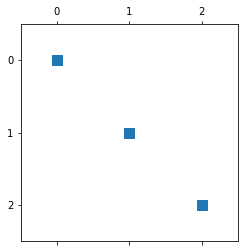

In [4]:
plt.spy(S)
plt.show()

### Compressed Sparse Row/Column Formats

One of the disadvantages of COO Matrices are that entries need not be ordered in any way, which can lead to inefficiencies in memory access in matrix-vector or matrix-matrix multiplication.

Commonly used formats which keeps entries in a sensible order (without additional structure assumed) are Compressed Sparse Row (CSR) and Compressed Sparse Column (CSC) matrices.  You might think of these as the sparse equivalents of row-major and column-major dense matrices.

We'll describe CSC matrices - the transpose is a CSR matrix.

If `S` is a CSC matrix with `m` rows, `n` columns, and `nnz` non-zeros, we specify `S` with three lists: `ptr` (length `n+1`), `row` (length `nnz`) and `val` (length `nnz`).  The non-zero row indices for column `j` are stored in `row[ptr[j]:ptr[j+1]]`, and the non-zero values for those rows are stored in `val[ptr[j]:ptr[j+1]]`.  If you're familiar with pointers in a language like C, `ptr` is an array of pointer offsets.

Basically, the non-zero entries for each column are stored in contiguous blocks of memory.  This can make it much faster to apply CSC matrices.

Scipy documentation is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)

In [5]:
ptr = [0,1,2,3]
row = [0,1,2]
val = [1,1,1]

S = sparse.csc_matrix((val, row, ptr), shape=(3,3))
S.toarray()

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

### Other Sparse Matrix Types

Other matrix types in `scipy.sparse` include:
* [`dia_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dia_matrix.html#scipy.sparse.dia_matrix), which is good for diagonal/banded matrices
* [`lil_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix), or a (row-based) list-of-lists matrix, which is good for mutating row operations
* [`bsr_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.bsr_matrix.html#scipy.sparse.bsr_matrix), or block sparse row, which is good for sparse matrices with dense blocks
* [`dok_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix), or dictionary of keys, which is good for when you want to access and change individual entries quickly.

### Changing formats

If you have a dense matrix, and want to convert it to a sparse matrix format, you can typicially just pass it to a sparse matrix constructor

In [6]:
A = np.eye(5) # identity
As = sparse.dia_matrix(A)
As

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements (1 diagonals) in DIAgonal format>

Sparse matrix formats have a `todense` method which converts to a dense matrix.

In [7]:
As.todense()

matrix([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

You can also us the `toarray` method to get a numpy array without the matrix wrapper

In [8]:
As.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

To convert between sparse matrix formats, you can use `tocsc`, `tocoo`, etc.

In [9]:
As2 = As.tolil()
As2

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in List of Lists format>

### Exercise

In this exercise, you will implement a basic Dictionary of Keys matrix.

The class should wrap a python dictionary, which takes tuples of ints as keys, and floats as values.  It should also store the shape of the matrix.

for example, the data for a $3\times 3$ identity matrix is

In [10]:
data = {(0,0): 1.0, (1,1): 1.0, (2,2): 1.0}

Implement the following methods:
* [`__getitem__`](https://docs.python.org/3/reference/datamodel.html#object.__getitem__) for accessing an element
* [`__setitem__`](https://docs.python.org/3/reference/datamodel.html#object.__setitem__) for setting a value (delete the key if the value is zero)
* `nnz()` to return the total number of non-zeros
* `matvec(x)` to apply the matrix to a vector, using equation {eq}`sparse_matvec`

In [ ]:
# your code here


## Saving and Loading Sparse Matrices

Dense matrices can be easily stored and read from comma-separated value formats using e.g. `np.genfromtxt` and `np.savetxt`.  Because sparse matrices can be stored more efficiently than dense matrices, they have special storage formats.

One source of sparse matrices which is used extensively for testing is the University of Florida Sparse Matrix Collection ([Link](https://sparse.tamu.edu/)).  As an example, we'll just read the `1138_bus.mtx` file, which is matrix-market format, and you can download from that linke.  This is a plain text file, with a header (every line begins with `%`), and the first row contains three integers: the number of rows, number of columns, and number of nonzeros in the matrix.  For `1138_bus.mtx`, this looks like:
```
%%MatrixMarket matrix coordinate real symmetric
%-------------------------------------------------------------------------------
% UF Sparse Matrix Collection, Tim Davis
% http://www.cise.ufl.edu/research/sparse/matrices/HB/1138_bus
% name: HB/1138_bus
% [S ADMITTANCE MATRIX 1138 BUS POWER SYSTEM, D.J.TYLAVSKY, JULY 1985.]
% id: 1
% date: 1985
% author: D. Tylavsky
% ed: I. Duff, R. Grimes, J. Lewis
% fields: title A name id date author ed kind
% kind: power network problem
%-------------------------------------------------------------------------------
1138 1138 2596
```
So the matrix is `1138 x 1138` with 2596 nonzeros.
Every subsequent row is in the form `row, column, data` - one nonzero in COO format.

Let's go ahead and load this matrix:

In [11]:
data = np.genfromtxt('1138_bus.mtx', comments='%') # skip any rows that begin with `%`
data.shape

(2597, 3)

the first non-comment row contains the size of the matrix, so we can handle it separately.

In [12]:
m, n = int(data[0,0]), int(data[0,1])
data = data[1:]

matrix market format uses the Fortran convention of beginning indexes at 1, so we need to subtract 1 from indices to get the correct Python indices

In [13]:
rows = data[:,0] - 1
cols = data[:,1] - 1
vals = data[:,2]
A = sparse.coo_matrix((vals, (rows, cols)), shape=(m,n))
A

<1138x1138 sparse matrix of type '<class 'numpy.float64'>'
	with 2596 stored elements in COOrdinate format>

Let's look at the difference between using the sparse matrix and a dense matrix for matrix-vector multiplications:

In [14]:
Acsr = A.tocsr()
Adense = A.todense()

In [15]:
import time
x = np.random.randn(n)
y = np.empty_like(x)

t0 = time.time()
y = Acsr @ x
t1 = time.time()
print("time for CSR multiply: {} sec.".format(t1 - t0))
tcsr = t1 - t0

t0 = time.time()
y = Adense @ x
t1 = time.time()
print("time for dense multiply: {} sec.".format(t1 - t0))
tdense = t1 - t0

print("CSR is {}x faster".format(tdense / tcsr))

time for CSR multiply: 0.0007445812225341797 sec.
time for dense multiply: 0.0055348873138427734 sec.
CSR is 7.4335574767851424x faster


Depending on what is happening on my system, using the sparse matrix is several times faster than using a dense matrix.